In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

### Set the configurations.

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

### Load the Cifar-10 data.

In [3]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
        del X_train, y_train
        del X_test, y_test
        print('Clear previously loaded data.')
    except:
        pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

### Extract features.

In [4]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

### Train SVM on features.

In [5]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-3, 1e-2]
regularization_strengths = [0.1, 0.5]

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

svm = LinearSVM()

for lr in learning_rates:
    for reg in regularization_strengths:
        loss_hist = svm.train(X_train_feats, y_train, learning_rate=lr, reg=reg, num_iters=1500, verbose=False)
        
        y_train_pred = svm.predict(X_train_feats)
        y_train_acc = np.mean(y_train == y_train_pred)
        
        y_val_pred = svm.predict(X_val_feats)
        y_val_acc = np.mean(y_val == y_val_pred)
        
        results[(lr, reg)] = (y_train_acc, y_val_acc)
        
        if y_val_acc > best_val:
            best_val = y_val_acc
            best_svm = svm

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-03 reg 1.000000e-01 train accuracy: 0.500041 val accuracy: 0.495000
lr 1.000000e-03 reg 5.000000e-01 train accuracy: 0.495755 val accuracy: 0.485000
lr 1.000000e-02 reg 1.000000e-01 train accuracy: 0.502878 val accuracy: 0.492000
lr 1.000000e-02 reg 5.000000e-01 train accuracy: 0.489163 val accuracy: 0.470000
best validation accuracy achieved during cross-validation: 0.495000


In [6]:
# Evaluate trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.45


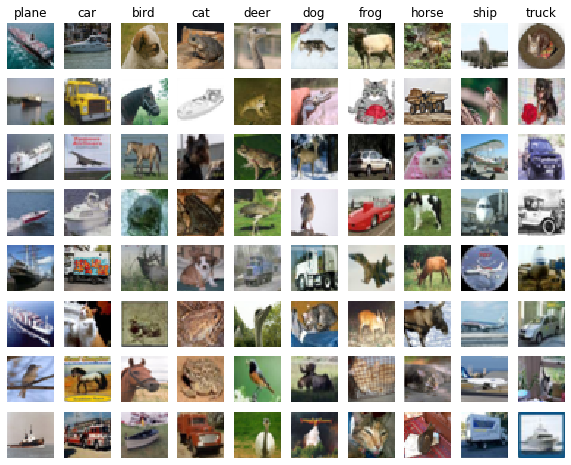

In [7]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Neural network on image features.

In [8]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 155)
(49000, 154)


In [9]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

results = {}
best_val = -1

hidden_size = [200, 400, 500]
learning_rates = [1e-1, 3e-1, 5e-1]
regularization_strengths = [1e-6, 1e-5, 1e-4, 1e-3]

for hs in hidden_size:    
    for lr in learning_rates:
        for reg in regularization_strengths:
            
            net = TwoLayerNet(input_dim, hs, num_classes)
            
            loss_hist = net.train(X_train_feats, y_train, X_val_feats, y_val,
                                  num_iters=1000, batch_size=200,
                                  learning_rate=lr, learning_rate_decay=0.95,
                                  reg=reg, verbose=False)

            y_train_pred = net.predict(X_train_feats)
            y_train_acc = np.mean(y_train == y_train_pred)

            y_val_pred = net.predict(X_val_feats)
            y_val_acc = np.mean(y_val == y_val_pred)

            results[(hs, lr, reg)] = (y_train_acc, y_val_acc)

            if y_val_acc > best_val:
                best_val = y_val_acc
                best_net = net

for hs, lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(hs, lr, reg)]
    print('hs %d lr %e reg %e train accuracy: %f val accuracy: %f' % (
                hs, lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

hs 200 lr 1.000000e-01 reg 1.000000e-06 train accuracy: 0.520020 val accuracy: 0.512000
hs 200 lr 1.000000e-01 reg 1.000000e-05 train accuracy: 0.522755 val accuracy: 0.515000
hs 200 lr 1.000000e-01 reg 1.000000e-04 train accuracy: 0.521633 val accuracy: 0.514000
hs 200 lr 1.000000e-01 reg 1.000000e-03 train accuracy: 0.521510 val accuracy: 0.498000
hs 200 lr 3.000000e-01 reg 1.000000e-06 train accuracy: 0.585551 val accuracy: 0.528000
hs 200 lr 3.000000e-01 reg 1.000000e-05 train accuracy: 0.589735 val accuracy: 0.574000
hs 200 lr 3.000000e-01 reg 1.000000e-04 train accuracy: 0.589245 val accuracy: 0.556000
hs 200 lr 3.000000e-01 reg 1.000000e-03 train accuracy: 0.580592 val accuracy: 0.558000
hs 200 lr 5.000000e-01 reg 1.000000e-06 train accuracy: 0.626592 val accuracy: 0.576000
hs 200 lr 5.000000e-01 reg 1.000000e-05 train accuracy: 0.617286 val accuracy: 0.565000
hs 200 lr 5.000000e-01 reg 1.000000e-04 train accuracy: 0.615061 val accuracy: 0.582000
hs 200 lr 5.000000e-01 reg 1.000

In [10]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.572
